In [1]:
import sys
sys.executable

'/Users/alecflowers/Documents/EPFL/2020_fall/ada_final_project/venv/bin/python3'

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt # needed for plotting
import matplotlib
import geopandas as gpd # for Geo-location filtering
from netCDF4 import Dataset as nc  # for loading standard climate date format (nc extension)
import netCDF4 # for loading standard climate date format (nc extension)
import xarray as xr # for handling climate data
#from pandarallel import pandarallel # for running pandas functions in parallel
#import multiprocessing # for general parallelizing of codes
import tqdm # for having progres bar
#from functools import partial # for full control over handling function arguemnts
#pandarallel.initialize(nb_workers=multiprocessing.cpu_count()-1)
from geopandas.tools import sjoin
import geopandas as gpd
from tqdm import tqdm # for having progres bar
tqdm.pandas()
import seaborn as sns
import scipy
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
#Extra statistical packages to understand the distribution of data
import powerlaw
#import pingouin as pg

In [7]:
from datetime import datetime, date, timedelta
from scipy import stats
import holidays
from timezonefinder import TimezoneFinderL
tf = TimezoneFinderL(in_memory=False)

from pytz import timezone
import pytz
utc = pytz.utc

In [8]:
import seaborn as sns
import plotly.express as px
import cufflinks as cf
import chart_studio.plotly as py
import plotly.graph_objects as go
%matplotlib inline

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
cf.go_offline()

In [9]:
from pandarallel import pandarallel # for running pandas functions in parallel
import multiprocessing # for general parallelizing of codes
import tqdm # for having progres bar
pandarallel.initialize(nb_workers=multiprocessing.cpu_count()-1)
from geopandas.tools import sjoin
from tqdm import tqdm # package used for having progres bar
tqdm.pandas()

INFO: Pandarallel will run on 7 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


/Users/alecflowers/Documents/EPFL/2020_fall/ada_final_project/venv/lib/python3.8/site-packages/tqdm/std.py:699: FutureWarning:

The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version



In this notebook we are going to take the data where we have added additional features and use these features to help us answer the quesitons we are asking. 

The additional features we are working with are:

**distance_from_home** - clear enough

**distance_from_previous_check** - ordere check-ins and calculate distance between one another

**season** - season

**tmin** - minimum temperature at that day of the check in

**tmax** - maximum temperature at that day of the check in

**pr** - precipitation at that day of the checkin

**tmin_house** -  minimum temperature at that day of the user home location

**tmax_house** - maximum temperature at that day of the user home location

**pr_house** - precipitation at that day of the user home location

**local_time** - local time with timezone of check in (original times were UTC)

**local_time_grouper** - local time without timezone so pandas can group

0) Initial Pre-processing

    - Getting dataframes in order, fixing few errors, adding some helper features
    
1) Data Distribution
    
    - Trying to understand how our data is distributed so we know what sort of statistical tests to look at and use

2) Seasons

    - The first question we want to understand is are there significant differences in travel between the seasons. We are looking into this as a starting point from our analysis and understand there are many different factors that can affect movement and mobility over a period of time as a couple of months. We will analyze our findings and then push deeper to see what else we can uncover. 

3) Weather

    - Weather is ubiquitous and we believe plays a role in how we as humans travel. We look at weather by day and try to understand the impact of weather and see if there is a statistically significant delta.
    
    - Note: We could potentially use weather at a checkpoint and look at probablity of distance traveled. 

4) Holidays

    - Lastly we want to understand how national holidays affect movement accross the country.
    

## 0) Pre-Processing

The data engineering takes a lot of time because we are dealing with so much data and location items. When we realized we needed data in a different manner, rather than re-run everything we just grabbed the data we need and merge it toghether here.

In [16]:
#Main dataframe
df_gowalla = pd.read_csv('./data/all_feat_gowalla.csv')
df_bright = pd.read_csv('./data/all_feat_bright.csv')

#This dataframe has weather by house location, we did this seperately and have to join them
df_gowalla_join = pd.read_csv('./data/home_and_checkin_with_states_gowalla.csv')
df_bright_join = pd.read_csv('./data/home_and_checkin_with_states_bright.csv')

In [17]:
df_gowalla_join.head()

,Unnamed: 0,user,user_house_lat,user_house_long,States of homes,geometry homes,checkin_time,latitude,longitude,country,name,date,tmin_house,tmax_house,pr_house,tmin_checkin,tmax_cehckin,pr_checkin
0,0,0,30.263544,-97.744633,Texas,POINT (-97.74463265845054 30.26354372623895),2010-10-19T23:55:27Z,30.235909,-97.795140,USA,Texas,2010-10-19,289.299988,302.299988,0.0,288.600006,302.100006,0.0
1,1,0,30.263544,-97.744633,Texas,POINT (-97.74463265845054 30.26354372623895),2010-10-18T22:17:43Z,30.269103,-97.749395,USA,Texas,2010-10-18,289.100006,301.799988,0.0,289.100006,301.799988,0.0
2,2,0,30.263544,-97.744633,Texas,POINT (-97.74463265845054 30.26354372623895),2010-10-17T23:42:03Z,30.255731,-97.763386,USA,Texas,2010-10-17,287.299988,301.799988,0.0,287.299988,301.799988,0.0
3,3,0,30.263544,-97.744633,Texas,POINT (-97.74463265845054 30.26354372623895),2010-10-17T19:26:05Z,30.263418,-97.757597,USA,Texas,2010-10-17,287.299988,301.799988,0.0,287.299988,301.799988,0.0
4,4,0,30.263544,-97.744633,Texas,POINT (-97.74463265845054 30.26354372623895),2010-10-16T18:50:42Z,30.274292,-97.740523,USA,Texas,2010-10-16,282.299988,301.299988,0.0,282.299988,301.299988,0.0


In [18]:
#Drop duplicates so we don't duplicate data. This is just to get the house weather into our main dataframe
df_gowalla_join = df_gowalla_join[['user','checkin_time', 'tmin_house', 'tmax_house', 'pr_house']].drop_duplicates()
df_bright_join = df_bright_join[['user','checkin_time', 'tmin_house', 'tmax_house', 'pr_house']].drop_duplicates()

Joining the data to get temperature by home location as well as by check in

In [19]:
df_gowalla = df_gowalla.merge(df_gowalla_join, how='left', on=['user','checkin_time'])

In [20]:
df_bright = df_bright.merge(df_bright_join, how='left', on=['user','checkin_time'])

Fixing mistake made earlier with season, had the wrong year.

In [21]:
df_bright['season'] = df_bright['season'].str.replace('winter_2010','winter_2009')
df_gowalla['season'] = df_gowalla['season'].str.replace('winter_2010','winter_2009')

In [22]:
#csv is all strings, make this datetime
df_bright['local_time_grouper'] = pd.to_datetime(df_bright['local_time_grouper'])
df_gowalla['local_time_grouper'] = pd.to_datetime(df_gowalla['local_time_grouper'])

Grabbing US holidays during our time period so we can throw them into graphs with reckless abandon and visualize things

In [23]:
us_holidays = holidays.UnitedStates()

sdate = df_bright['local_time_grouper'].min()
edate = df_bright['local_time_grouper'].max()
dates = pd.date_range(sdate,edate-timedelta(days=1),freq='d').normalize()
holiday = dates.map(us_holidays.get)

df_holiday_all = pd.Series(holiday,dates)
df_holiday_all_series = pd.Series(holiday,dates)
df_holiday_all = pd.DataFrame(df_holiday_all).reset_index(drop=False).rename({'index':'date', 0:'holiday'},axis=1)
df_holiday = pd.Series(holiday, dates).dropna()

We did an analysis of the number of check ins and there are days that just don't have enough check ins and are causing to much variance in our statistics. 
We filter out these days where we have to few check ins to make meaningful comparisons.

<AxesSubplot:xlabel='local_time_grouper'>

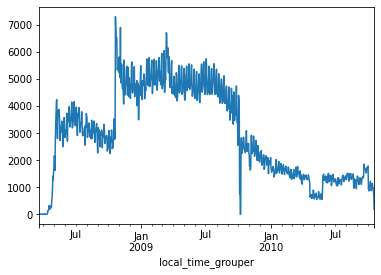

In [24]:
#Graphing the count of checkins by day
df_bright.groupby(pd.Grouper(key="local_time_grouper", freq="1D"))['latitude'].count().plot()

<AxesSubplot:xlabel='local_time_grouper'>

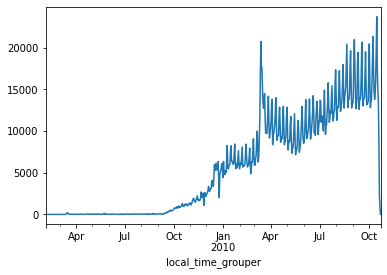

In [25]:
#Graphing the count of checkins by day
df_gowalla.groupby(pd.Grouper(key="local_time_grouper", freq="1D"))['latitude'].count().plot()

In [26]:
#before this date the sample size of check ins is to small...
df_bright = df_bright[df_bright['local_time_grouper'] > pd.Timestamp(date(2008,4,27))]
df_gowalla = df_gowalla[df_gowalla['local_time_grouper'] > pd.Timestamp(date(2009,9,11))]

In [27]:
#change kelvin to celsius so it makes sense for users
df_bright['tmax_house_c'] = df_bright['tmax_house'] - 273.15
df_gowalla['tmax_house_c'] = df_gowalla['tmax_house'] - 273.15

In [28]:
#Add holidays to the dataframe
df_gowalla['holiday'] = df_gowalla['local_time_grouper'].apply(us_holidays.get)
df_bright['holiday'] = df_bright['local_time_grouper'].apply(us_holidays.get)

### If I want to drop a subset of users with not enough check ins run this
Some users have such a few amount of check ins, this is to see how the cells pas this would run if we limited to only a subset of active users.

**Only run this cells if we want to look at a subsection**

In [18]:
#Count number of days that each user has checked in
days_checked_in_b = df_bright.groupby(['user', pd.Grouper(key="local_time_grouper",
                                                          freq="1D")])['latitude'].count().groupby('user').count()

In [19]:
#Count number of days that each user has checked in
days_checked_in_g = df_gowalla.groupby(['user', pd.Grouper(key="local_time_grouper",
                                                           freq="1D")])['latitude'].count().groupby('user').count()

In [20]:
#Threshold users to select only those that have checked in for more than a certain number of days
days_checked_in_b = days_checked_in_b[days_checked_in_b >= 0]
days_checked_df_b = pd.DataFrame(days_checked_in_b).reset_index(drop=False).drop('latitude', axis=1)

In [21]:
days_checked_in_g = days_checked_in_g[days_checked_in_g >= 0]
days_checked_df_g = pd.DataFrame(days_checked_in_g).reset_index(drop=False).drop('latitude', axis=1)

In [22]:
#Merge all the data back onto this selected subset to get rid of the users we don't want
df_bright = days_checked_df_b.merge(df_bright, how='left', on = 'user')
df_gowalla = days_checked_df_g.merge(df_gowalla, how='left', on = 'user')

{'whiskers': [<matplotlib.lines.Line2D at 0x7fdca8780fd0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fdc9bff46d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fdca8780c70>],
 'medians': [<matplotlib.lines.Line2D at 0x7fdc9bff4dc0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fdca0ef8160>],
 'means': []}

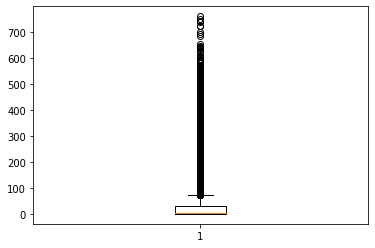

In [23]:
#Check out the results in a boxplot
plt.boxplot(df_bright.groupby(['user', pd.Grouper(key="local_time_grouper",
                                                  freq="1D")])['latitude'].count().groupby('user').count())

Loading data for graphing purposes

In [24]:
#Data for simon to load
# simon_df = df_bright_short.groupby(['user',pd.Grouper(key="local_time_grouper", freq="1D")]).agg({'distance_from_home': 'mean', 'tmax_house': 'max', 'user_house_lat':'max', 'user_house_long':'max'})
# simon_df = simon_df.reset_index(drop=False)
# simon_df.to_csv('./data/bright_groupby_day_user_small.csv', index=False)

## 1) Data Distribution

For our statistical tests we want to analyze the data a bit to see if we can understand or identify what sort of distribution it is coming from. This will help us better decide which sort of statistical tests we can use to determine significance when comparing two groups of data.

In [29]:
df_distribution_bright = df_bright.groupby(['user',pd.Grouper(key="local_time_grouper",
                                                              freq="1D")]).agg({'distance_from_home': 'mean'})

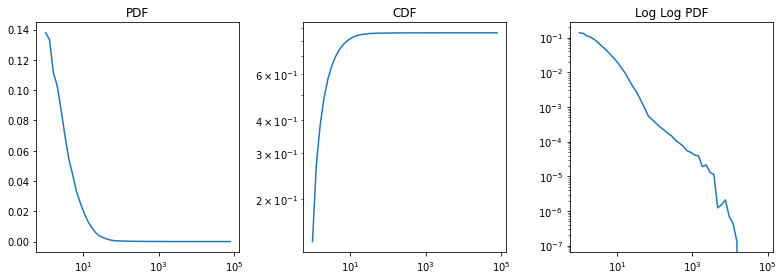

In [30]:
w_hist, w_bins = np.histogram(df_distribution_bright['distance_from_home'], bins = np.logspace(0,5,50), density=True)
w_bin_centers = w_bins[:-1]

fig, axs = plt.subplots(1,3,figsize=(11,4))
axs[0].plot(w_bin_centers, w_hist)
axs[1].plot(w_bin_centers, np.cumsum(w_hist))
axs[2].plot(w_bin_centers, w_hist)

#axs[0].set_yscale("log")
axs[0].set_xscale("log")
axs[1].set_yscale("log")
axs[1].set_xscale("log")
axs[2].set_yscale("log")
axs[2].set_xscale("log")

axs[0].set_title('PDF')
axs[1].set_title('CDF')
axs[2].set_title('Log Log PDF')

plt.tight_layout()

Looking at our data my initial impression was that we had data that came from a power law (pareto) distribution. As it was very right skewed. I found a test online that helped determine if the data we have comes from a power law distribution. 

https://arxiv.org/abs/1305.0215

https://github.com/jeffalstott/powerlaw

We fit a powerlaw distributions and display the best fit parameter alpha and xmin which is the optimal xmin value to start evaluating the distribution from

In [31]:
#Note we set xmax here since there is a limit to the amount of distance that can be traveled in one day.
results = powerlaw.Fit(df_distribution_bright['distance_from_home'].sample(10000), xmax=10000)
print(results.power_law.alpha)
print(results.power_law.xmin)

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/Users/alecflowers/Documents/EPFL/2020_fall/ada_final_project/venv/lib/python3.8/site-packages/powerlaw.py:699: RuntimeWarning:

invalid value encountered in true_divide

/Users/alecflowers/Documents/EPFL/2020_fall/ada_final_project/venv/lib/python3.8/site-packages/powerlaw.py:699: RuntimeWarning:

divide by zero encountered in true_divide



1.4083432209044688
1.9644621350115201


/Users/alecflowers/Documents/EPFL/2020_fall/ada_final_project/venv/lib/python3.8/site-packages/powerlaw.py:1178: RuntimeWarning:

overflow encountered in double_scalars

/Users/alecflowers/Documents/EPFL/2020_fall/ada_final_project/venv/lib/python3.8/site-packages/powerlaw.py:825: RuntimeWarning:

invalid value encountered in multiply



PDF - Plot a log log pdf

CCDF - Plot a log log ccdf (complementary cumulative distribution function)

From this image here it looks like a pretty good fit

<AxesSubplot:>

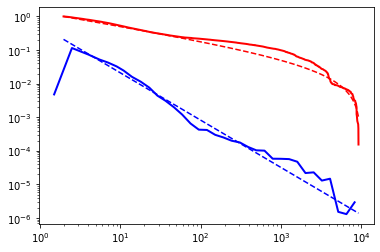

In [32]:
fig2 = results.plot_pdf(color='b', linewidth=2)
results.power_law.plot_pdf(color='b', linestyle='--', ax=fig2)
results.plot_ccdf(color='r', linewidth=2, ax=fig2)
results.power_law.plot_ccdf(color='r', linestyle='--', ax=fig2)

We can compare the tuned power law distribution to other distributions. If the first value is R and represents the likelyhood ratio between the two distributions. The number is positive if it is more likely to be from the first distribution and negative if it is more likely to be from the second. 

The second value is a p_value that shows the significance of the direction of the likelyhood ratio.

The power law does a much better job than an exponential distribution of fitting our data, however it looks like a lognormal distribution is much more likely.

In [33]:
results.distribution_compare('power_law', 'exponential')

/Users/alecflowers/Documents/EPFL/2020_fall/ada_final_project/venv/lib/python3.8/site-packages/powerlaw.py:699: RuntimeWarning:

invalid value encountered in true_divide



(11442.190748621964, 0.0)

In [34]:
results.distribution_compare('power_law', 'lognormal')

(-81.87039074689467, 7.078393463796654e-23)

Lets check out what the log of this looks like

In [35]:
df_distribution_bright_log = (df_distribution_bright['distance_from_home']+1).parallel_apply(np.log)

<AxesSubplot:ylabel='Frequency'>

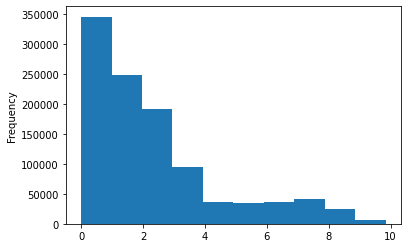

In [36]:
df_distribution_bright_log.plot.hist()

We repeat this analysis for Gowalla:

In [37]:
df_distribution_gowalla = df_gowalla.groupby(['user',pd.Grouper(key="local_time_grouper",
                                                                freq="1D")]).agg({'distance_from_home': 'mean'})

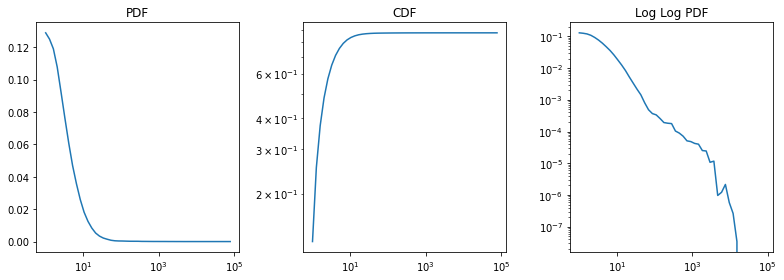

In [38]:
w_hist, w_bins = np.histogram(df_distribution_gowalla['distance_from_home'],
                              bins = np.logspace(0,5,50), density=True)
w_bin_centers = w_bins[:-1]

fig, axs = plt.subplots(1,3,figsize=(11,4))
axs[0].plot(w_bin_centers, w_hist)
axs[1].plot(w_bin_centers, np.cumsum(w_hist))
axs[2].plot(w_bin_centers, w_hist)

#axs[0].set_yscale("log")
axs[0].set_xscale("log")
axs[1].set_yscale("log")
axs[1].set_xscale("log")
axs[2].set_yscale("log")
axs[2].set_xscale("log")

axs[0].set_title('PDF')
axs[1].set_title('CDF')
axs[2].set_title('Log Log PDF')

plt.tight_layout()

Looking at our data my initial impression was that we had data that came from a power law (pareto) distribution. As it was very right skewed. I found a test online that helped determine if the data we have comes from a power law distribution. 

https://arxiv.org/abs/1305.0215

https://github.com/jeffalstott/powerlaw

We fit a powerlaw distributions and display the best fit parameter alpha and xmin which is the optimal xmin value to start evaluating the distribution from

In [39]:
#Note we set xmax here since there is a limit to the amount of distance that can be traveled in one day.
results = powerlaw.Fit(df_distribution_gowalla['distance_from_home'].sample(10000), xmax=10000)
print(results.power_law.alpha)
print(results.power_law.xmin)

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/Users/alecflowers/Documents/EPFL/2020_fall/ada_final_project/venv/lib/python3.8/site-packages/powerlaw.py:699: RuntimeWarning:

invalid value encountered in true_divide



1.411062284939299
1.8814259982359642


PDF - Plot a log log pdf

CCDF - Plot a log log ccdf (complementary cumulative distribution function)

From this image here it looks like a pretty good fit

<AxesSubplot:>

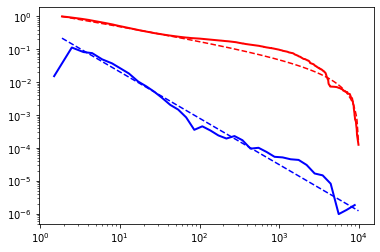

In [40]:
fig2 = results.plot_pdf(color='b', linewidth=2)
results.power_law.plot_pdf(color='b', linestyle='--', ax=fig2)
results.plot_ccdf(color='r', linewidth=2, ax=fig2)
results.power_law.plot_ccdf(color='r', linestyle='--', ax=fig2)

We can compare the tuned power law distribution to other distributions. If the first value is R and represents the likelyhood ratio between the two distributions. The number is positive if it is more likely to be from the first distribution and negative if it is more likely to be from the second. 

The second value is a p_value that shows the significance of the direction of the likelyhood ratio.

The power law does a much better job than an exponential distribution of fitting our data, however it looks like a lognormal distribution is much more likely.

In [41]:
results.distribution_compare('power_law', 'exponential')

/Users/alecflowers/Documents/EPFL/2020_fall/ada_final_project/venv/lib/python3.8/site-packages/powerlaw.py:699: RuntimeWarning:

invalid value encountered in true_divide



(14354.150058474848, 0.0)

In [42]:
results.distribution_compare('power_law', 'lognormal')

(-86.47753249657544, 8.2415732080503405e-25)

Lets check out what the log of this looks like

In [43]:
df_distribution_gowalla_log = (df_distribution_gowalla['distance_from_home']+1).parallel_apply(np.log)

<AxesSubplot:ylabel='Frequency'>

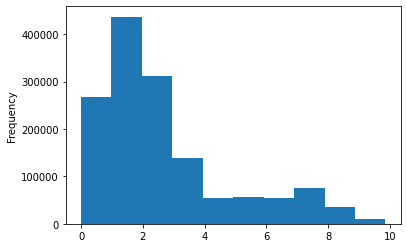

In [44]:
df_distribution_gowalla_log.plot.hist()

## 2) Seasons

Build a summary table of holidays by season for the data story

In [45]:
def seasons(date):
    
    spring_2008 = datetime.strptime('2008-03-19', '%Y-%m-%d')
    summer_2008 = datetime.strptime('2008-06-20', '%Y-%m-%d')
    autumn_2008 = datetime.strptime('2008-09-22', '%Y-%m-%d')
    winter_2008 = datetime.strptime('2008-12-21', '%Y-%m-%d')
    spring_2009 = datetime.strptime('2009-03-20', '%Y-%m-%d')
    summer_2009 = datetime.strptime('2009-06-20', '%Y-%m-%d')
    autumn_2009 = datetime.strptime('2009-09-22', '%Y-%m-%d')
    winter_2009 = datetime.strptime('2009-12-21', '%Y-%m-%d')
    spring_2010 = datetime.strptime('2010-03-20', '%Y-%m-%d')
    summer_2010 = datetime.strptime('2010-06-21', '%Y-%m-%d')
    autumn_2010 = datetime.strptime('2010-09-22', '%Y-%m-%d')
    winter_2010 = datetime.strptime('2010-12-21', '%Y-%m-%d')
    
    if spring_2008 >= date:
        return 'winter_2007'
    elif summer_2008 >= date:
        return 'spring_2008'
    elif autumn_2008 >= date:
        return 'summer_2008'
    elif winter_2008 >= date:
        return 'autumn_2008'
    elif spring_2009 >= date:
        return 'winter_2008'
    elif summer_2009 >= date:
        return 'spring_2009'
    elif autumn_2009 >= date:
        return 'summer_2009'
    elif winter_2009 >= date:
        return 'autumn_2009'
    elif spring_2010 >= date:
        return 'winter_2009'
    elif summer_2010 >= date:
        return 'spring_2010'
    elif autumn_2010 >= date:
        return 'summer_2010' 
    elif winter_2010 >= date:
        return 'autumn_2010'
    else:
        return np.nan

In [46]:
df_holiday_all['seasons'] = df_holiday_all['date'].parallel_apply(seasons)

In [47]:
#Order how I want the seasons to be shown
df_holiday_all['seasons'] = pd.Categorical(df_holiday_all['seasons'], ["spring_2008", "spring_2009", "spring_2010", 'summer_2008',
                                               'summer_2009', 'summer_2010', 'autumn_2008', 'autumn_2009',
                                              'autumn_2010', 'winter_2008', 'winter_2009'])

In [48]:
#Munging to create table
holiday_by_season = pd.DataFrame(pd.DataFrame(df_holiday_all.value_counts()).reset_index(drop=False).sort_values(['seasons','date']).drop(0,axis=1).groupby('seasons')['holiday'].apply(lambda x: ', '.join(x)))
holiday_table_web = holiday_by_season.merge(pd.DataFrame(df_holiday_all.groupby('seasons')['holiday'].count()), left_index=True, right_index=True).rename({'holiday_x':'holidays','holiday_y':'count holidays'}, axis=1)

In [49]:
#save table
# with open('./data/holiday_table.html', 'w') as fo:
#     fo.write(holiday_table_web.to_html())

### a) Brightkite Seasons
     i) First we take a quick peek at just taking the mean distance from home. We break the check ins up by season and look at the mean and median distance from home. This measures on average how far are people away from their houses. We think there is a better statistic to analyze and use which we explain below.
        
     ii) Next we group by user and day and take the average distance from home by user by day. When looking into changes over a timeframe like seasons we believe this statistic makes more sense as we are tying our statistic to the user. The questions we are asking here is - on average by user, by day, is there a significant difference in travel from home between the seasons?

In [50]:
winter_2008 = df_bright.groupby('season')['distance_from_home'].get_group('winter_2008')
autumn_2009 = df_bright.groupby('season')['distance_from_home'].get_group('autumn_2009')
spring_2009 = df_bright.groupby('season')['distance_from_home'].get_group('spring_2009')
summer_2009 = df_bright.groupby('season')['distance_from_home'].get_group('summer_2009')

In [51]:
print('Winter Mean: ',winter_2008.mean())
print('Autumn Mean: ',autumn_2009.mean())
print('Spring Mean: ',spring_2009.mean())
print('Summer Mean: ',summer_2009.mean())

Winter Mean:  259.6283323408879
Autumn Mean:  232.97129384249962
Spring Mean:  264.56619133588396
Summer Mean:  273.8423318286595


In [52]:
print('Winter Median: ',winter_2008.median())
print('Autumn Median: ',autumn_2009.median())
print('Spring Median: ',spring_2009.median())
print('Summer Median: ',summer_2009.median())

Winter Median:  3.5944210423527383
Autumn Median:  3.711873598370192
Spring Median:  3.5674315694072254
Summer Median:  3.720265803177895


In [53]:
w_hist, w_bins = np.histogram(winter_2008, bins = np.logspace(0,5,50), density=True)
w_bin_centers = w_bins[:-1]

a_hist, a_bins = np.histogram(autumn_2009, bins = np.logspace(0,5,50), density=True)
a_bin_centers = a_bins[:-1]

s_hist, s_bins = np.histogram(spring_2009, bins = np.logspace(0,5,50), density=True)
s_bin_centers = s_bins[:-1]

su_hist, su_bins = np.histogram(summer_2009, bins = np.logspace(0,5,50), density=True)
su_bin_centers = su_bins[:-1]

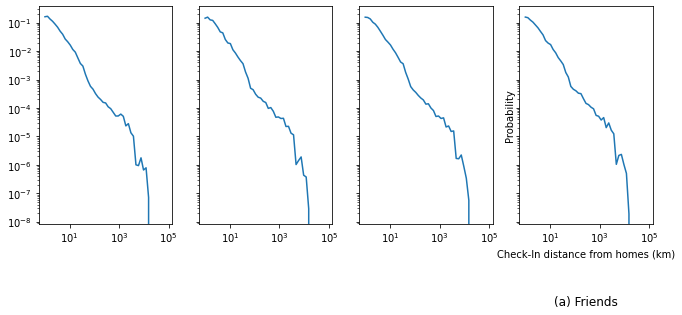

In [54]:
fig, axs = plt.subplots(1,4,figsize=(11,4), sharex = True, sharey=True)
axs[0].plot(w_bin_centers, w_hist)
axs[1].plot(a_bin_centers, a_hist)
axs[2].plot(s_bin_centers, s_hist)
axs[3].plot(su_bin_centers, su_hist)

for ax in axs.flat:
    ax.set_yscale("log")
    ax.set_xscale("log")
#Puts in final labels
plt.ylabel("Probability")
plt.xlabel("Check-In distance from homes (km)")
plt.title("(a) Friends", y=-.4)

plt.show()

In [55]:
#Groupbing by user and by day
season_by_day = df_bright.groupby(['user',
                                   pd.Grouper(key="local_time_grouper", 
                                              freq="1D")]).agg({'season':'max',
                                                                'distance_from_home': 'mean'}).groupby('season')['distance_from_home']

In [56]:
w_2008 = season_by_day.get_group('winter_2008')
a_2009 = season_by_day.get_group('autumn_2009')
s_2009 = season_by_day.get_group('spring_2009')
su_2009 = season_by_day.get_group('summer_2009')

In [57]:
print('Winter Median: ',w_2008.median())
print('Autumn Median: ',a_2009.median())
print('Spring Median: ',s_2009.median())
print('Summer Median: ',su_2009.median())

Winter Median:  4.492299011578362
Autumn Median:  4.803411957438309
Spring Median:  4.523767233110856
Summer Median:  4.878054463128546


In [58]:
print('Winter Mean: ',w_2008.mean())
print('Autumn Mean: ',a_2009.mean())
print('Spring Mean: ',s_2009.mean())
print('Summer Mean: ',su_2009.mean())

Winter Mean:  240.09441769633148
Autumn Mean:  248.96565671246677
Spring Mean:  251.63128735463638
Summer Mean:  263.0113825112412


In [59]:
w_hist, w_bins = np.histogram(w_2008, bins = np.logspace(0,5,50), density=True)
w_bin_centers = w_bins[:-1]

a_hist, a_bins = np.histogram(a_2009, bins = np.logspace(0,5,50), density=True)
a_bin_centers = a_bins[:-1]

s_hist, s_bins = np.histogram(s_2009, bins = np.logspace(0,5,50), density=True)
s_bin_centers = s_bins[:-1]

su_hist, su_bins = np.histogram(su_2009, bins = np.logspace(0,5,50), density=True)
su_bin_centers = su_bins[:-1]

In [60]:
plt.rcParams.update({'font.size': 16})

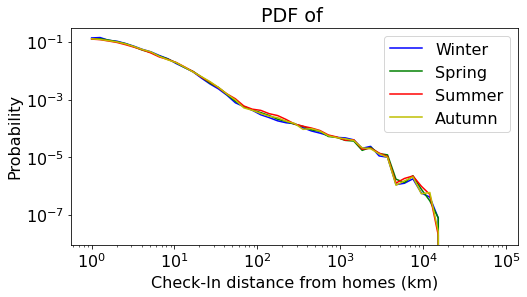

In [61]:
fig, axs = plt.subplots(figsize=(8,4), sharex = True, sharey=True)
axs.plot(w_bin_centers, w_hist, label='Winter', color='b')
axs.plot(s_bin_centers, s_hist, label='Spring', color='g')
axs.plot(su_bin_centers, su_hist, label='Summer', color='r')
axs.plot(a_bin_centers, a_hist, label='Autumn', color='y')

axs.set_yscale("log")
axs.set_xscale("log")
#Puts in final labels
#plt.xlim(left=100)
plt.ylabel("Probability")
plt.xlabel("Check-In distance from homes (km)")
plt.title("PDF of ")
plt.legend()

plt.show()

### a) Gowalla Seasons

In [62]:
#Groupbing by user and by day
season_by_day_g = df_gowalla.groupby(['user',pd.Grouper(key="local_time_grouper", freq="1D")]).agg({'season':'max', 'distance_from_home': 'mean'}).groupby('season')['distance_from_home']

In [63]:
w_2008_g = season_by_day_g.get_group('winter_2009')
a_2009_g = season_by_day_g.get_group('autumn_2010')
s_2009_g = season_by_day_g.get_group('spring_2010')
su_2009_g = season_by_day_g.get_group('summer_2010')

In [64]:
print('Winter Median: ',w_2008_g.median())
print('Autumn Median: ',a_2009_g.median())
print('Spring Median: ',s_2009_g.median())
print('Summer Median: ',su_2009_g.median())

Winter Median:  5.817463524266168
Autumn Median:  6.884467244290626
Spring Median:  6.220516284906566
Summer Median:  7.005287875690196


In [65]:
print('Winter Mean: ',w_2008_g.mean())
print('Autumn Mean: ',a_2009_g.mean())
print('Spring Mean: ',s_2009_g.mean())
print('Summer Mean: ',su_2009_g.mean())

Winter Mean:  261.93724610238604
Autumn Mean:  318.0467445774322
Spring Mean:  272.55584343296994
Summer Mean:  299.8694752316254


In [66]:
w_hist_g, w_bins = np.histogram(w_2008_g, bins = np.logspace(0,5,50), density=True)
w_bin_centers_g = w_bins[:-1]

a_hist_g, a_bins = np.histogram(a_2009_g, bins = np.logspace(0,5,50), density=True)
a_bin_centers_g = a_bins[:-1]

s_hist_g, s_bins = np.histogram(s_2009_g, bins = np.logspace(0,5,50), density=True)
s_bin_centers_g = s_bins[:-1]

su_hist_g, su_bins = np.histogram(su_2009_g, bins = np.logspace(0,5,50), density=True)
su_bin_centers_g = su_bins[:-1]

In [67]:
plt.rcParams.update({'font.size': 16})

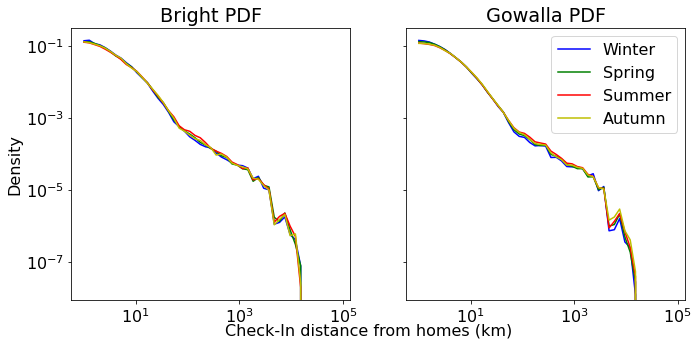

In [68]:
fig, axs = plt.subplots(1,2,figsize=(11,5), sharex = True, sharey=True)
axs[1].plot(w_bin_centers_g, w_hist_g, label='Winter', color='b')
axs[1].plot(s_bin_centers_g, s_hist_g, label='Spring', color='g')
axs[1].plot(su_bin_centers_g, su_hist_g, label='Summer', color='r')
axs[1].plot(a_bin_centers_g, a_hist_g, label='Autumn', color='y')

axs[0].plot(w_bin_centers, w_hist, label='Winter', color='b')
axs[0].plot(s_bin_centers, s_hist, label='Spring', color='g')
axs[0].plot(su_bin_centers, su_hist, label='Summer', color='r')
axs[0].plot(a_bin_centers, a_hist, label='Autumn', color='y')

axs[0].set_title('Bright PDF')
axs[0].set_ylabel('Density')
axs[1].set_title('Gowalla PDF')

for ax in axs.flat:
    ax.set_yscale("log")
    ax.set_xscale("log")
#Puts in final labels
#plt.xlim(left=100)
fig.text(0.5, 0.04, 'Check-In distance from homes (km)', ha='center', va='center')
plt.legend()

plt.savefig('./data/seasons_pdf.png')
plt.show()

Now we look into our other statistic which is the distance from previous checkpoint

In [69]:
# winter_2008 = df_bright.groupby('season')['distance_from_prev_check'].get_group('winter_2008')
# autumn_2009 = df_bright.groupby('season')['distance_from_prev_check'].get_group('autumn_2009')
# spring_2009 = df_bright.groupby('season')['distance_from_prev_check'].get_group('spring_2009')
# summer_2009 = df_bright.groupby('season')['distance_from_prev_check'].get_group('summer_2009')

In [70]:
# print('Winter Mean: ',winter_2008.median())
# print('Autumn Mean: ',autumn_2009.median())
# print('Spring Mean: ',spring_2009.median())
# print('Summer Mean: ',summer_2009.median())

In [71]:
# print('Winter Mean: ',winter_2008.mean())
# print('Autumn Mean: ',autumn_2009.mean())
# print('Spring Mean: ',spring_2009.mean())
# print('Summer Mean: ',summer_2009.mean())

In [72]:
# w_hist, w_bins = np.histogram(winter_2008, bins = np.logspace(0,5,50), density=True)
# w_bin_centers = w_bins[:-1]

# a_hist, a_bins = np.histogram(autumn_2009, bins = np.logspace(0,5,50), density=True)
# a_bin_centers = a_bins[:-1]

# s_hist, s_bins = np.histogram(spring_2009, bins = np.logspace(0,5,50), density=True)
# s_bin_centers = s_bins[:-1]

# su_hist, su_bins = np.histogram(summer_2009, bins = np.logspace(0,5,50), density=True)
# su_bin_centers = su_bins[:-1]

In [73]:
# fig, axs = plt.subplots(1,4,figsize=(11,4), sharex = True, sharey=True)
# axs[0].plot(w_bin_centers, w_hist)
# axs[1].plot(a_bin_centers, a_hist)
# axs[2].plot(s_bin_centers, s_hist)
# axs[3].plot(su_bin_centers, su_hist)

# for ax in axs.flat:
#     ax.set_yscale("log")
#     ax.set_xscale("log")
# #Puts in final labels
# plt.ylabel("Probability")
# plt.xlabel("Check-In distance from homes (km)")
# plt.title("(a) Friends", y=-.4)

# plt.show()

In [74]:
# fig, axs = plt.subplots(figsize=(8,4), sharex = True, sharey=True)
# axs.plot(w_bin_centers, w_hist, label='winter')
# axs.plot(s_bin_centers, s_hist, label='spring')
# axs.plot(su_bin_centers, su_hist, label='summer')
# axs.plot(a_bin_centers, a_hist, label='autumn')

# axs.set_yscale("log")
# axs.set_xscale("log")
# #Puts in final labels
# #plt.xlim(left=100)
# plt.ylabel("Probability")
# plt.xlabel("Check-In distance from homes (km)")
# plt.title("(a) Friends", y=-.4)
# plt.legend()

# plt.show()

## 3) Weather

In [104]:
#This cell is to only keep check ins that are a certain distance from home
df_bright_short = df_bright[df_bright['distance_from_home'] < 100]
df_gowalla_short = df_gowalla[df_gowalla['distance_from_home'] < 100]

In [106]:
#Group by user and day and calculate our statistic of interest, mean of distance_from_home
rain_user_day_bright = df_bright_short.groupby(['user',pd.Grouper(key="local_time_grouper", freq="1D")]).agg({'pr_house': 'max', 'distance_from_home': 'mean'})
rain_user_day_gowalla = df_gowalla_short.groupby(['user',pd.Grouper(key="local_time_grouper", freq="1D")]).agg({'pr_house': 'max', 'distance_from_home': 'mean'})

Lets try splitting up the days into rainy and non rainy days at a users home location to see if there is a meaningful difference in movement in users.

In [77]:
rain_user_day['distance_from_home'] += .1
rain_user_day['distance_from_home_log'] = rain_user_day['distance_from_home'].transform(np.log)

In [78]:
rain_user_day[rain_user_day['pr_house'] > 0]['distance_from_home'].mean()

8.382900473152272

In [79]:
rain_user_day[rain_user_day['pr_house'] == 0]['distance_from_home'].mean()

8.66339821611939

Just looking at the means there does seem to be a difference. Can we turn to statistics to help us identify if this is meaningful?

https://stats.stackexchange.com/questions/86490/t-tests-for-power-law-distributed-data
In trying to understand if there was a difference between two means I first ran things through a t-test. But it is clear that we have data that is right skewed and looks to follow an exp or power law (pareto) distribution.

In this case I took inspiration from the stack overflow and look at two more tests. The Kruskal-Wallis test is 

In [108]:
rain_bright = rain_user_day_bright[rain_user_day_bright['pr_house'] > 0]['distance_from_home']
rain_gowalla = rain_user_day_gowalla[rain_user_day_gowalla['pr_house'] > 0]['distance_from_home']

In [109]:
no_rain_bright = rain_user_day_bright[rain_user_day_bright['pr_house'] == 0]['distance_from_home']
no_rain_gowalla = rain_user_day_gowalla[rain_user_day_gowalla['pr_house'] == 0]['distance_from_home']

In [122]:
print(rain_bright.mean())
print(no_rain_bright.mean())
print(rain_bright.median())
print(no_rain_bright.median())

8.282900473152269
8.56339821611939
3.0248330078256616
3.1356352612335567


In [121]:
print(rain_gowalla.mean())
print(no_rain_gowalla.mean())
print(rain_gowalla.median())
print(no_rain_gowalla.median())

9.522760433744665
10.060772073685017
4.528511299633982
4.7001325799683435


/Users/alecflowers/Documents/EPFL/2020_fall/ada_final_project/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



<AxesSubplot:xlabel='distance_from_home'>

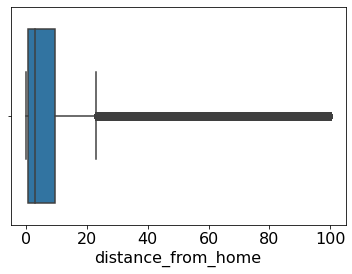

In [120]:
sns.boxplot(rain_bright)

/Users/alecflowers/Documents/EPFL/2020_fall/ada_final_project/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



<AxesSubplot:xlabel='distance_from_home'>

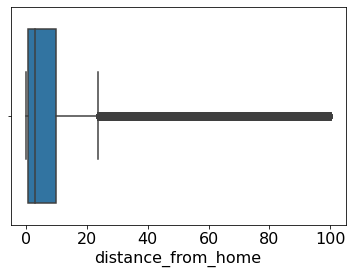

In [119]:
sns.boxplot(no_rain_bright)

In [110]:
scipy.stats.kruskal(rain_bright, no_rain_bright, nan_policy = 'omit')

KruskalResult(statistic=76.84310494786828, pvalue=1.8509331344455745e-18)

In [111]:
scipy.stats.kruskal(rain_gowalla, no_rain_gowalla, nan_policy = 'omit')

KruskalResult(statistic=259.4123875713348, pvalue=2.3046350608369658e-58)

This last 

In [82]:
no_rain = rain_user_day[rain_user_day['pr_house'] == 0]
rain = rain_user_day[rain_user_day['pr_house'] > 0]

In [83]:
no_rain = no_rain.reset_index(drop=True)
no_rain['ind'] = 'no_rain'
#no_rain = no_rain.drop(['pr_house','distance_from_home_log'], axis=1)

In [84]:
rain = rain.reset_index(drop=True)
rain['ind'] = 'rain'
#rain = rain.drop(['pr_house','distance_from_home_log'], axis=1)

In [85]:
rain_df = no_rain.append(rain)

pcompfit <- glm(log(values)~ind,family=Gamma(link=log),data=pdata)

summary(pcompfit, dispersion=1) # dispersion = 1 for exponential

In [86]:
model = smf.glm(formula = 'np.log(distance_from_home)~ind',
                family=sm.families.Gamma(link=sm.genmod.families.links.log()), data = rain_df)
model_fit = model.fit(scale = 1)

In [87]:
model_fit.summary()

/Users/alecflowers/Documents/EPFL/2020_fall/ada_final_project/venv/lib/python3.8/site-packages/statsmodels/genmod/families/family.py:735: RuntimeWarning:

invalid value encountered in log



<class 'statsmodels.iolib.summary.Summary'>
"""
                     Generalized Linear Model Regression Results                      
======================================================================================
Dep. Variable:     np.log(distance_from_home)   No. Observations:               929874
Model:                                    GLM   Df Residuals:                   929872
Model Family:                           Gamma   Df Model:                            1
Link Function:                            log   Scale:                          1.0000
Method:                                  IRLS   Log-Likelihood:                    nan
Date:                        Fri, 18 Dec 2020   Deviance:                   1.8601e+07
Time:                                21:57:55   Pearson chi2:                 3.96e+06
No. Iterations:                            10                                         
Covariance Type:                    nonrobust                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.0950      0.001    -70.678      0.000      -0.098      -0.092
ind[T.rain]    -0.0381      0.002    -18.055      0.000      -0.042      -0.034
===============================================================================
"""

Actually first I'm going to look into temperature as I looked into rain above and then I will see if the combination of them tells me anything exciting.

I am taking maximum tempature since that is more likely to be the temperature during the day than at night and more reflective of the temperature when people are active and going to be traveling.

In [123]:
temp_user_day_bright = df_bright_short.groupby(['user',pd.Grouper(key="local_time_grouper", freq="1D")]).agg({'tmax_house': 'max', 'tmax_house_c': 'max','distance_from_home': 'mean'})
temp_user_day_gowalla = df_gowalla_short.groupby(['user',pd.Grouper(key="local_time_grouper", freq="1D")]).agg({'tmax_house': 'max', 'tmax_house_c': 'max','distance_from_home': 'mean'})

In [124]:
#Split the data into quartile
low_quart_bright = temp_user_day_bright['tmax_house_c'].quantile(.33)
high_quart_bright = temp_user_day_bright['tmax_house_c'].quantile(.66)
print('Low Quartile: ',low_quart_bright)
print('High Quartile: ',high_quart_bright)
low_quart_gowalla = temp_user_day_gowalla['tmax_house_c'].quantile(.33)
high_quart_gowalla = temp_user_day_gowalla['tmax_house_c'].quantile(.66)
print('Low Quartile: ',low_quart_gowalla)
print('High Quartile: ',high_quart_gowalla)

Low Quartile:  17.350000000000023
High Quartile:  26.149987792968773
Low Quartile:  20.649987792968773
High Quartile:  29.350000000000023


Break up the data into the appropriate quartile and see how things look!

In [125]:
hot_bright = temp_user_day_bright[temp_user_day_bright['tmax_house_c'] > high_quart_bright]
lukewarm_bright = temp_user_day_bright[(temp_user_day_bright['tmax_house_c'] > low_quart_bright) & (temp_user_day_bright['tmax_house_c'] <= high_quart_bright)]
cold_bright = temp_user_day_bright[temp_user_day_bright['tmax_house_c'] <= low_quart_bright]

In [126]:
hot_gowalla = temp_user_day_gowalla[temp_user_day_gowalla['tmax_house_c'] > high_quart_gowalla]
lukewarm_gowalla = temp_user_day_gowalla[(temp_user_day_gowalla['tmax_house_c'] > low_quart_gowalla) & (temp_user_day_gowalla['tmax_house_c'] <= high_quart_gowalla)]
cold_gowalla = temp_user_day_gowalla[temp_user_day_gowalla['tmax_house_c'] <= low_quart_gowalla]

In [133]:
print(cold_bright['distance_from_home'].mean())
print(lukewarm_bright['distance_from_home'].mean())
print(hot_bright['distance_from_home'].mean())

print(cold_bright['distance_from_home'].median())
print(lukewarm_bright['distance_from_home'].median())
print(hot_bright['distance_from_home'].median())

8.279565498508319
8.65866742493077
8.407898467597052
2.9133980237760264
3.179668072705809
3.191342040236808


In [132]:
print(cold_gowalla['distance_from_home'].mean())
print(lukewarm_gowalla['distance_from_home'].mean())
print(hot_gowalla['distance_from_home'].mean())

print(cold_gowalla['distance_from_home'].median())
print(lukewarm_gowalla['distance_from_home'].median())
print(hot_gowalla['distance_from_home'].median())

9.491736172427283
10.218578789268609
9.927130734044974
4.181962083688026
4.7242096708388575
5.006971254985976


In [130]:
scipy.stats.kruskal(cold_bright, lukewarm_bright, hot_bright, nan_policy = 'omit')

KruskalResult(statistic=13745525.515838558, pvalue=0.0)

In [131]:
scipy.stats.kruskal(cold_gowalla, lukewarm_gowalla, hot_gowalla, nan_policy = 'omit')

KruskalResult(statistic=18448325.220755473, pvalue=0.0)

### ASIDE
This was a bit of a research section

In [98]:
df_bright['trip'] = df_bright['distance_from_prev_check'] > 100

In [100]:
grouped = df_bright.groupby([pd.Grouper(key="local_time_grouper", freq="1D")])

In [101]:
user_grouped = df_bright.groupby(['user',pd.Grouper(key="local_time_grouper", freq="1D")])

In [102]:
user_week_grouped = df_bright.groupby(['user',pd.Grouper(key="local_time_grouper", freq="1W")])

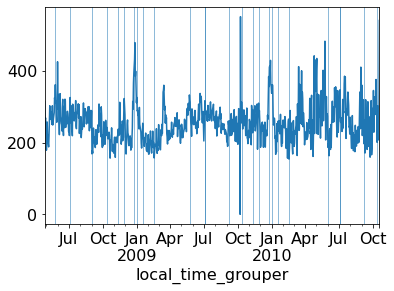

In [103]:
pd.DataFrame(user_grouped['distance_from_home'].mean()).reset_index(drop=False).groupby(pd.Grouper(key="local_time_grouper", freq="1D")).mean()['distance_from_home'].plot()
for date, holiday in df_holiday.items():
    plt.axvline(date, lw=.5)

<AxesSubplot:xlabel='local_time_grouper'>

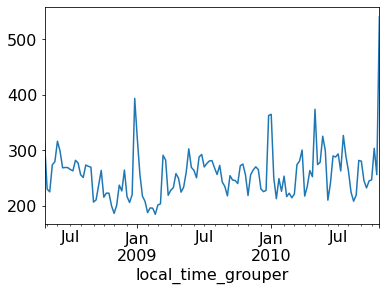

In [100]:
pd.DataFrame(user_grouped['distance_from_home'].mean()).reset_index(drop=False).groupby(pd.Grouper(key="local_time_grouper", freq="1W")).mean()['distance_from_home'].plot()

<AxesSubplot:xlabel='local_time_grouper'>

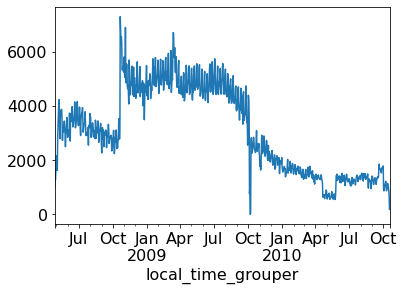

In [101]:
grouped['user'].count().plot()

In [102]:
grouped[['distance_from_prev_check']].mean()

,distance_from_prev_check
local_time_grouper,
2008-04-27,86.576190
2008-04-28,110.946615
2008-04-29,74.067690
2008-04-30,99.828221
2008-05-01,69.628648
...,...
2010-10-14,11.998676
2010-10-15,19.174363
2010-10-16,38.795585


<AxesSubplot:xlabel='local_time_grouper'>

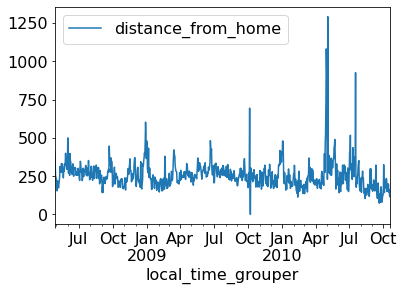

In [103]:
grouped[['distance_from_home']].mean().plot()

<AxesSubplot:xlabel='local_time_grouper'>

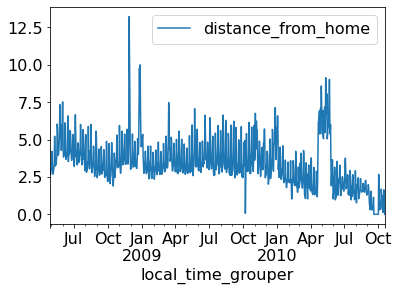

In [104]:
grouped[['distance_from_home']].median().plot()

<AxesSubplot:xlabel='local_time_grouper'>

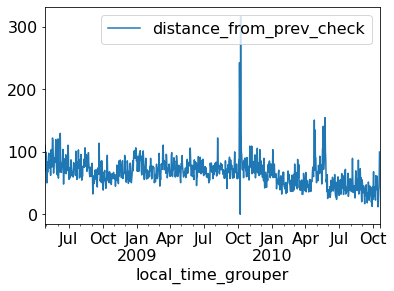

In [105]:
grouped[['distance_from_prev_check']].mean().plot()

In [106]:
df_bright.columns

Index(['user', 'Unnamed: 0', 'user_house_lat', 'user_house_long',
       'States of homes', 'geometry homes', 'checkin_time', 'latitude',
       'longitude', 'country', 'name', 'date', 'tmin', 'tmax', 'pr',
       'us_holiday', 'season', 'distance_from_home', 'time_obj',
       'latitude_prev_check', 'longitude_prev_check',
       'distance_from_prev_check', 'timezone', 'utc', 'local_time',
       'local_time_grouper', 'tmin_house', 'tmax_house', 'pr_house',
       'tmax_house_c', 'holiday', 'trip'],
      dtype='object')

<AxesSubplot:>

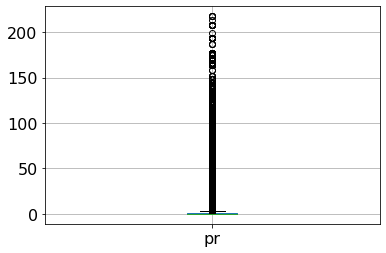

In [107]:
df_bright.boxplot('pr')

5% of the time people move and make a checkpoint that is 100km from a previous one. I will denote this as a trip

In [112]:
df_bright['trip'].sum()/df_bright.shape[0]

0.05074266641631433

Each user will make on average 5 trips longer than 100km... when do they choose tomake these trips?

In [113]:
df_bright['trip'].sum()/len(df_bright['user'].unique())

4.784171453525479

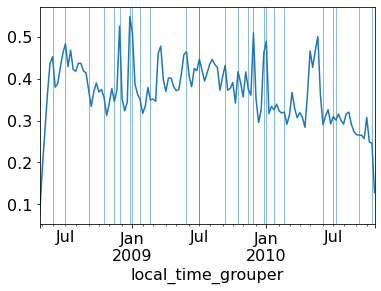

In [114]:
pd.DataFrame(user_week_grouped['trip'].sum()).reset_index(drop=False).groupby('local_time_grouper')['trip'].mean().plot()
for date, holiday in df_holiday.items():
    plt.axvline(date, lw=.5)

# 4) Holidays

In [115]:
# let's first collect dates adjacent to holidays in calender
df_holiday_all_series.name = "holiday_affected"
df_holiday_all_df = df_holiday_all_series.to_frame()
df_holiday_all_df.reset_index(inplace=True)
# We take two days prior and after each holiday as holiday affected days
holiday_indices = df_holiday_all_df[~df_holiday_all_df["holiday_affected"].isna()].index
for ind in holiday_indices:
    for j in [-2,-1, 1, 2]:
        try:
            df_holiday_all_df.iloc[ind+j,1] = df_holiday_all_df.iloc[ind,1]
        except:
            pass
df_holiday_all_df.rename(columns={'index': 'date'}, inplace=True)

In [116]:
# preparing a columns that we can use to merge the data obtained just above
df_bright["local_time_grouper_date"] = df_bright["local_time_grouper"].parallel_apply(lambda x: x.replace(hour=0, minute=0, second=0, microsecond=0))

In [117]:
# adding data regarding the type of the day (being affected or not) to the checkin dataframe 
df_bright_holiday_neigbours = df_bright.merge(df_holiday_all_df,
                                               left_on="local_time_grouper_date",
                                               right_on="date")
# let's seperate the checkins based on the holiday influence 
df_bright_holiday_affected = df_bright_holiday_neigbours[~df_bright_holiday_neigbours["holiday_affected"].isna()]
df_bright_holiday_non_affected = df_bright_holiday_neigbours[df_bright_holiday_neigbours["holiday_affected"].isna()]
# Here we filter the data according to the length of the trip
df_bright_holiday_affected_short = df_bright_holiday_affected[df_bright_holiday_affected['distance_from_home'] < 100]
df_bright_holiday_non_affected_short = df_bright_holiday_non_affected[df_bright_holiday_non_affected['distance_from_home'] < 100]

In order to normalize the data w.r.t. number of dates and users we here group them by date and user

In [118]:
user_day_brightkite_affected_short = df_bright_holiday_affected_short.groupby(['user',pd.Grouper(key="local_time_grouper", freq="1D")]).agg({'distance_from_home': 'mean'})
user_day_brightkite_non_affected_short = df_bright_holiday_non_affected_short.groupby(['user',pd.Grouper(key="local_time_grouper", freq="1D")]).agg({'distance_from_home': 'mean'})

In [119]:
print(f"{user_day_brightkite_affected_short.mean()[0] = }\n{user_day_brightkite_non_affected_short.mean()[0] = }")

user_day_brightkite_affected_short.mean()[0] = 8.964426224952003
user_day_brightkite_non_affected_short.mean()[0] = 8.371531433989883


#### The mean of the short distance traveled **per person per day** is ***higher*** in holiday affected days 

In [120]:
user_day_brightkite_affected = df_bright_holiday_affected.groupby(['user',pd.Grouper(key="local_time_grouper", freq="1D")]).agg({'distance_from_home': 'mean'})
user_day_brightkite_non_affected = df_bright_holiday_non_affected.groupby(['user',pd.Grouper(key="local_time_grouper", freq="1D")]).agg({'distance_from_home': 'mean'})

In [121]:
# let's find out if our data is normally distributed. It gives us the hint regarding the statistic tests that we can use
normality_check = pg.normality(user_day_brightkite_affected['distance_from_home'])
print(normality_check)

                           W  pval  normal
distance_from_home  0.269136   0.0   False


/home/afalsafi/.local/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning:

p-value may not be accurate for N > 5000.



#### considering that the data is not normally distributed we would use non parametric tests such as Kruskal-Wallis test 

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kruskal.html

https://en.wikipedia.org/wiki/Kruskal%E2%80%93Wallis_one-way_analysis_of_variance

In [122]:
scipy.stats.kruskal(user_day_brightkite_affected_short['distance_from_home'],
                    user_day_brightkite_non_affected_short['distance_from_home'],
                    nan_policy = 'omit')

KruskalResult(statistic=92.79319276371875, pvalue=5.805449272069545e-22)

#### Very low ***P_value*** confirms that we have a significant difference between the mean distances traveled per day per user in ```holiday affectd``` days compared with ``` non holiday affected days``` considering the trips below 100 KM

In [123]:
user_day_brightkite_affected = df_bright_holiday_affected.groupby(['user',pd.Grouper(key="local_time_grouper", freq="1D")]).agg({'distance_from_home': 'mean'})
user_day_brightkite_non_affected = df_bright_holiday_non_affected.groupby(['user',pd.Grouper(key="local_time_grouper", freq="1D")]).agg({'distance_from_home': 'mean'})

In [124]:
print(f"{user_day_brightkite_affected.mean()[0] = }\n{user_day_brightkite_non_affected.mean()[0] = }")

user_day_brightkite_affected.mean()[0] = 273.2064378572036
user_day_brightkite_non_affected.mean()[0] = 246.84746479097183


#### The mean of the distance traveled **per person per day** is ***higher*** in holiday affected days 
#### the same analysis is here carried out for all checkins no matter what distance they have from users' house

In [125]:
normality_check = pg.normality(user_day_brightkite_affected['distance_from_home'])
print(normality_check)

                           W  pval  normal
distance_from_home  0.269136   0.0   False


/home/afalsafi/.local/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning:

p-value may not be accurate for N > 5000.



In [126]:
scipy.stats.kruskal(user_day_brightkite_affected['distance_from_home'],
                    user_day_brightkite_non_affected['distance_from_home'],
                    nan_policy = 'omit')

KruskalResult(statistic=653.3547701911476, pvalue=4.1640662318000345e-144)

#### Very low ***P_value*** confirms that we have a significant difference between the mean distances traveled per day per user in ```holiday affectd``` days VS. ``` non holiday affected days```

In [127]:
# prepare brightkite checkins for plotting the mean distance traveled by each user per week
df_bright['trip'] = df_bright['distance_from_prev_check'] > 100

df_bright['local_time_grouper'] = pd.to_datetime(df_bright['local_time_grouper'])

grouped_b = df_bright.groupby([pd.Grouper(key="local_time_grouper", freq="1D")])

user_grouped_b = df_bright.groupby(['user',pd.Grouper(key="local_time_grouper", freq="1D")])

user_week_grouped_b = df_bright.groupby(['user',pd.Grouper(key="local_time_grouper", freq="1W")])

In [128]:
# prepare gowalla checkins for plotting the mean distance traveled by each user per week
df_gowalla['trip'] = df_gowalla['distance_from_prev_check'] > 100

df_gowalla['local_time_grouper'] = pd.to_datetime(df_gowalla['local_time_grouper'])

grouped_g = df_gowalla.groupby([pd.Grouper(key="local_time_grouper", freq="1D")])

user_grouped_g = df_gowalla.groupby(['user',pd.Grouper(key="local_time_grouper", freq="1D")])

user_week_grouped_g = df_gowalla.groupby(['user',pd.Grouper(key="local_time_grouper", freq="1W")])

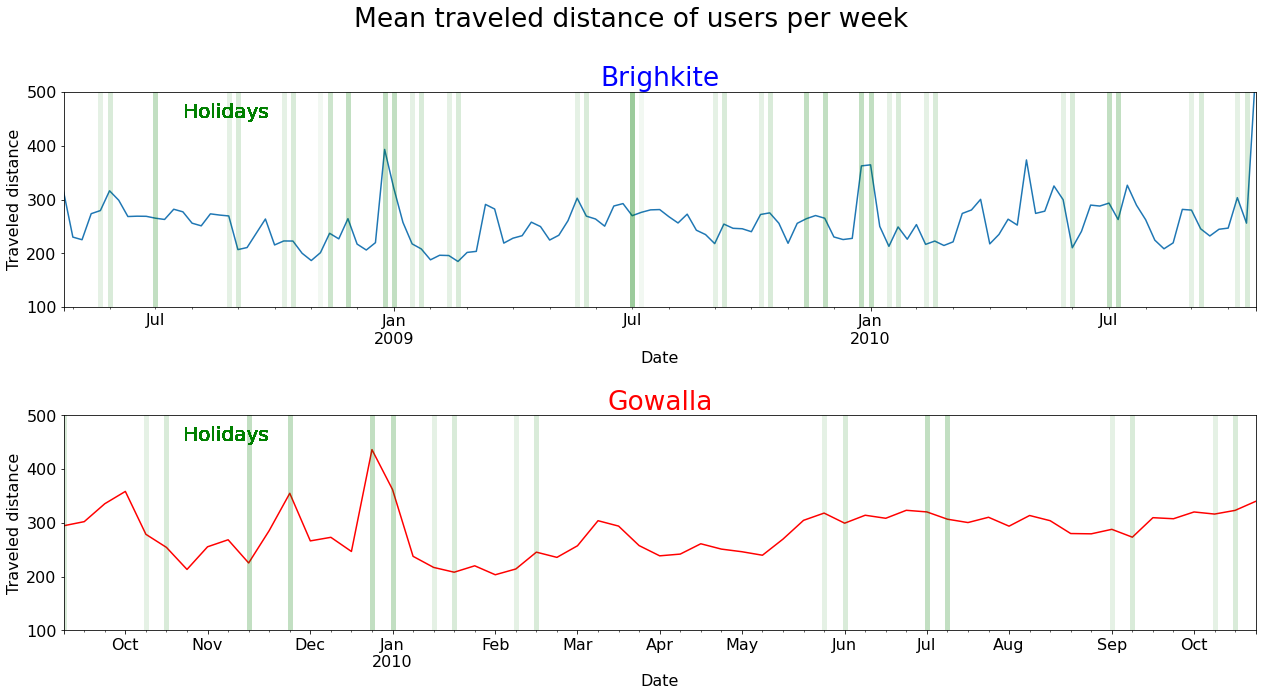

In [129]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(18,10))
ax = axs[0]
ax.set_ylim([100,500])
matplotlib.rcParams.update({'font.size': 22})

pd.DataFrame(user_grouped_b['distance_from_home'].mean()).reset_index(drop=False).groupby(pd.Grouper(key="local_time_grouper",
                                                                                                     freq="1W")).mean()['distance_from_home'].plot(ax = ax)
for date, holiday in df_holiday.items():
    dates = [date - timedelta(days=2),
             date - timedelta(days=1),
             date,
             date + timedelta(days=1),
             date + timedelta(days=2)]
    for dat in dates:
        ax.axvline(dat, lw=5, alpha = 0.05, color = 'green')
    ax.set_title("Brighkite",color = "blue")
    ax.set_xlabel("Date")
    ax.set_ylabel("Traveled distance")
    ax.text(0.1, 0.95, "Holidays", transform=ax.transAxes, fontsize=20,
        verticalalignment='top', color = "green")
ax = axs[1]
ax.set_ylim([100,500])
pd.DataFrame(user_grouped_g['distance_from_home'].mean()).reset_index(drop=False).groupby(pd.Grouper(key="local_time_grouper", freq="1W")).mean()['distance_from_home'].plot(ax=ax, color = 'red')
for date, holiday in df_holiday.items():
    dates = [date - timedelta(days=2),
             date - timedelta(days=1),
             date,
             date + timedelta(days=1),
             date + timedelta(days=2)]
    for dat in dates:
        plt.axvline(dat, lw=5, alpha = 0.05, color = 'green')
    ax.set_title("Gowalla", color ="red")
    ax.set_xlabel("Date")
    ax.set_ylabel("Traveled distance")
    ax.text(0.1, 0.95, "Holidays", transform=ax.transAxes, fontsize=20,
    verticalalignment='top', color = "green")
fig.suptitle("Mean traveled distance of users per week")
plt.tight_layout()
fig.savefig("holiday.png", dpi = 300)
